In [7]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = 'https://github.com/pytorch/tutorials/raw/main/_static/'
FILENAME = 'mnist.pkl.gz'

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open('wb').write(content)

In [8]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f,
                                                              encoding='latin-1')

(50000, 784)

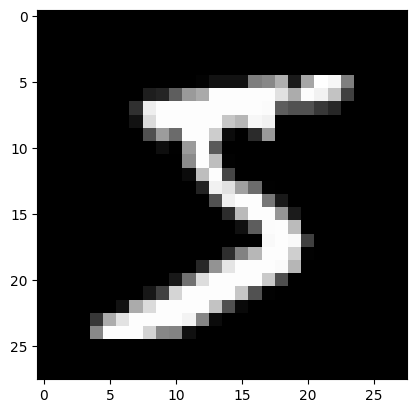

In [9]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')
x_train.shape

In [10]:
import torch

# PyTorch uses `torch.tensor`, rather than numpy arrays, so we need to convert our data
# For this, we use map function, to apply `torch.tensor` to all items
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
x_train_shape_rows, c = x_train.shape
print(f'x_train: \n\t{x_train} \ny_train:\n\t {y_train}')
print(f'x_train shape: \n\t{x_train.shape} \ny_train shape: \n\t{y_train.shape}')
print(f'y_train min: \n\t{y_train.min()} \ny_train max: \n\t{y_train.max()}')

x_train: 
	tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) 
y_train:
	 tensor([5, 0, 4,  ..., 8, 4, 8])
x_train shape: 
	torch.Size([50000, 784]) 
y_train shape: 
	torch.Size([50000])
y_train min: 
	0 
y_train max: 
	9


In [11]:
import math

# We are initializing the weights here with Xavier initialization (by multiplying with 1/sqrt(n))
weights = torch.rand(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [12]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [13]:
batch_size = 64 # batch size

xb = x_train[0:batch_size] # a mini-batch
preds = model(xb) # Predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.3522, -2.3519, -2.1555, -2.2285, -2.3676, -2.3182, -2.3946, -2.2598,
        -2.3034, -2.3181], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [14]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [15]:
yb = y_train[0:batch_size]
print(loss_func(preds, yb))

tensor(2.3047, grad_fn=<NegBackward0>)


In [16]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [17]:
print(accuracy(preds, yb))

tensor(0.0781)


In [18]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((x_train_shape_rows - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.inference_mode():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [19]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0817, grad_fn=<NegBackward0>) tensor(1.)


# Refactor using `nn.Module`

In [20]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [21]:
import torch.nn.functional as F
loss_func = F.cross_entropy

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2897, grad_fn=<NllLossBackward0>)


In [24]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

# Refactor using nn.Linear

In [25]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, xb):
        return self.linear(xb)

In [26]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3547, grad_fn=<NllLossBackward0>)


In [36]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
epochs = 1
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((x_train_shape_rows-1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3304, grad_fn=<NllLossBackward0>)
tensor(0.1108, grad_fn=<NllLossBackward0>)


# Refactor using Dataset

In [37]:
from torch.utils.data import TensorDataset

# Both can be combined in a single `TensorDataset`, which will be easier to iterate over and slice
train_ds = TensorDataset(x_train, y_train)

xb, yb = train_ds[i*batch_size : i*batch_size+batch_size]

# Refactor using `DataLoader`

In [38]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size)

# Add validation

In [39]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

In [40]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

        model.eval()
        with torch.inference_mode():
            valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

        print(epoch, valid_loss / len(valid_dl))

0 tensor(2.1099)
0 tensor(1.9450)
0 tensor(1.5574)
0 tensor(1.4135)
0 tensor(1.3604)
0 tensor(1.2024)
0 tensor(1.1518)
0 tensor(1.1160)
0 tensor(0.8856)
0 tensor(0.7620)
0 tensor(0.7810)
0 tensor(0.7727)
0 tensor(0.9592)
0 tensor(1.0740)
0 tensor(0.9483)
0 tensor(0.6552)
0 tensor(0.7341)
0 tensor(0.6009)
0 tensor(0.6519)
0 tensor(0.5977)
0 tensor(0.7073)
0 tensor(0.7384)
0 tensor(0.6134)
0 tensor(0.6210)
0 tensor(0.6694)
0 tensor(0.5588)
0 tensor(0.5244)
0 tensor(0.5599)
0 tensor(0.5323)
0 tensor(0.5119)
0 tensor(0.5027)
0 tensor(0.5170)
0 tensor(0.5110)
0 tensor(0.4888)
0 tensor(0.5298)
0 tensor(0.5400)
0 tensor(0.4761)
0 tensor(0.4655)
0 tensor(0.4891)
0 tensor(0.4691)
0 tensor(0.4556)
0 tensor(0.4550)
0 tensor(0.4712)
0 tensor(0.4582)
0 tensor(0.4542)
0 tensor(0.4626)
0 tensor(0.4446)
0 tensor(0.4447)
0 tensor(0.4730)
0 tensor(0.4426)
0 tensor(0.4585)
0 tensor(0.4327)
0 tensor(0.4287)
0 tensor(0.4498)
0 tensor(0.4320)
0 tensor(0.4221)
0 tensor(0.4406)
0 tensor(0.4630)
0 tensor(0.415

# Create fit() and get_data()

In [41]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)